## Background

In fastai Part 1 Lesson 7 (Chapter 8 of the textbook), we are introduced to the concept of **weight decay**, where the sum of the squared weights multiplied by a factor `wd` is added to the loss. In practice, instead of adding `wd` times the sum of squared weights to the loss (which would result in a large values of loss which destabilizes training), we add the derivative of that to the parameters' gradients. In pseudo code:

```
for param in model.parameters():
  param.grad += wd * sum(params)
```

By increasing the loss with the squared sum of weights, we are forcing the model to minimize the weights when it minimizes the loss, which makes the model generalize better (as large weights result in a neural net function with sharp peaks and troughs that can overfit to the training data).

In this notebook I'll train on the MovieLens 100k dataset using different values of weight decay and then plotting both the resulting training and validation loss curves and weight distribution to see how weight decay affects the training process and the resulting model.

## Create `DataLoaders` and `Learner`

I'l re-use the code from Chapter 8 to create `DataLoaders` and the `Learner`.

In [1]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [2]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', usecols=(0,1), names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [4]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [5]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,294,Money Talks (1997),3
1,486,"Crossing Guard, The (1995)",4
2,13,High Noon (1952),5
3,878,My Life as a Dog (Mitt liv som hund) (1985),5
4,433,Star Wars (1977),5
5,847,"Streetcar Named Desire, A (1951)",3
6,833,Akira (1988),4
7,503,"Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)",3
8,5,"Last of the Mohicans, The (1992)",1
9,868,Stand by Me (1986),4


In the text, the following `Learner` resulted in the lowest validation loss (`0.821688`) so I'll just use that in this experiment.

In [6]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

I'll do an initial training to sort my head around how I'm going to collect data during the experiment.

In [7]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.882671,0.955993,00:12
1,0.654915,0.892832,00:12
2,0.525330,0.872967,00:12
3,0.436863,0.858952,00:12
4,0.438653,0.854505,00:12


## Planning the Experiment

I'll be trying that same learning process (5 epochs, 5e-3 learning rate) with different weight decay `wd` values (from `0.0001` to `10.0`). Once the experiment is done, I want to visualize the following for all `wd` values:

- training loss curve .
- validation loss curve.
- distribution of model parameters.

I'll reference the [`plot_loss`](https://github.com/fastai/fastai/blob/785ec908c7f75a272c718dd0df53822bdf5e9e0e/fastai/learner.py#L597) source code for how to capture those values from the `Learner`'s `Recorder` object.


But first, I'll plot the losses using that `plot_loss` function to have a baseline reference:

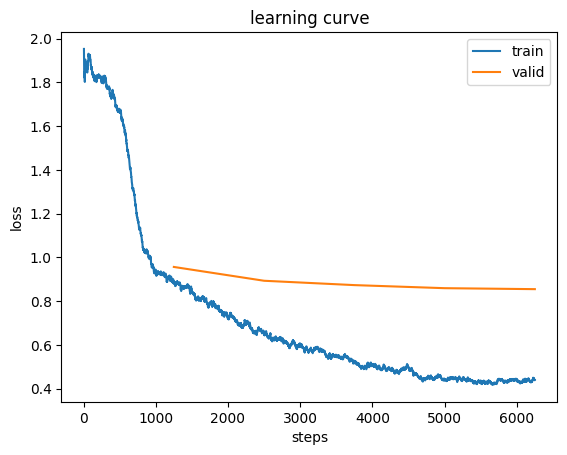

In [8]:
learn.recorder.plot_loss();

### Plotting Loss Values

The following line in `plot_loss` plots the training loss:

```python
ax.plot(list(range(skip_start, len(self.losses))), self.losses[skip_start:], label='train')
```

I'll see if I can recreate that plot:

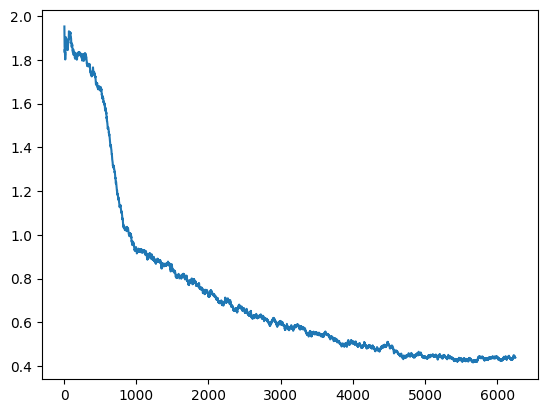

In [9]:
ax=plt.gca()
ax.plot(list(range(5, len(learn.recorder.losses))), learn.recorder.losses[5:], label='train');

Cool, that looks the same! Now for the validation loss:

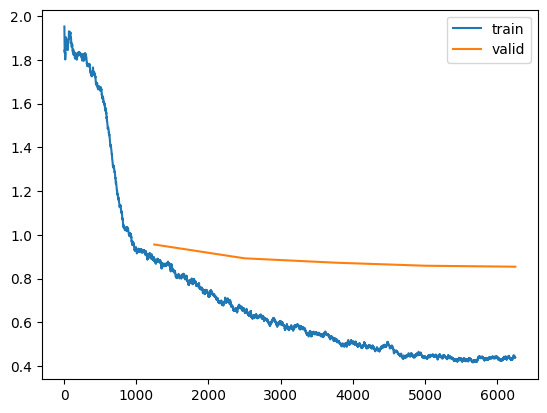

In [10]:
ax=plt.gca()
ax.plot(list(range(5, len(learn.recorder.losses))), learn.recorder.losses[5:], label='train');
idx = (np.array(learn.recorder.iters)<5).sum()
valid_col = learn.recorder.metric_names.index('valid_loss') - 1
ax.plot(learn.recorder.iters[idx:], L(learn.recorder.values[idx:]).itemgot(valid_col), label='valid')
ax.legend();

Nice, I'm able to recreate `plot_loss` using the raw data recorded in the `Recorder`.

## Plotting Distribution of Weights

Next, I want to be able to visualize (and calculate summary statistics for) the weights of the model.

The model has four sets of parameters: the user and item weights, and the user and item biases.

In [11]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [12]:
for p in learn.model.parameters():
  print(p.shape)

torch.Size([944, 50])
torch.Size([1665, 50])
torch.Size([944, 1])
torch.Size([1665, 1])


Let's take a look at the first set of parameters, which are the `u_weight` (user weight) parameters. This is the embedding with 50 latent factors for each user.

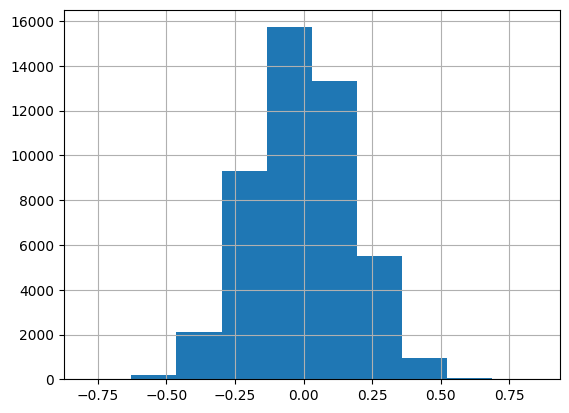

In [13]:
pd.Series(first(learn.model.parameters()).flatten().detach().numpy()).hist();

Next, let's look at the bias parameters for the users (`u_bias`):

In [14]:
u_bias_params = next(itertools.islice(learn.model.parameters(), 2, None))

In [15]:
u_bias_params.shape

torch.Size([944, 1])

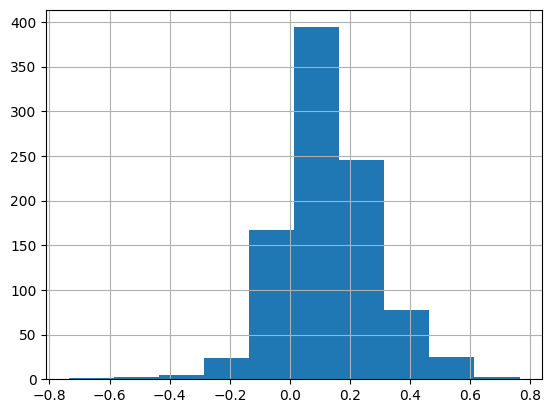

In [16]:
pd.Series(u_bias_params.flatten().detach().numpy()).hist();

Looking at all of the parameters:

In [17]:
torch.nn.utils.parameters_to_vector(learn.model.parameters()).shape, 944*50 + 944*1 + 1665*50 + 1665*1

(torch.Size([133059]), 133059)

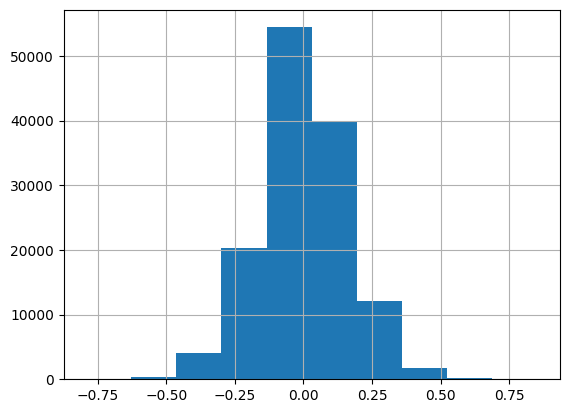

In [18]:
pd.Series(torch.nn.utils.parameters_to_vector(learn.model.parameters()).detach().numpy()).hist();

Now I know how to access and plot the training loss, validation loss and model weights.

## Estimating Runtime and Storage Size

Each model takes about 1 minute to run on Colab. I trained on Paperspace CPUs but it was taking 30+ seconds per epoch (while it takes 10-14 seconds on Colab). I have a 2015 Mac so I can't install fastai locally (if I'm interpreting [this note correctly](https://github.com/fastai/fastai/tree/master#:~:text=Mac%20is%20not%20supported)).


Originally I was going to use `torch.arange` to create weight decay values (without subtracting `1e-6` from the upper bound as I eventually did below), but it acculumated floating point error. The following tensor should stop at `0.0990` but goes up to `0.1000` because of floating point error.

In [19]:
torch.arange(0.01, 0.1, 0.001)

tensor([0.0100, 0.0110, 0.0120, 0.0130, 0.0140, 0.0150, 0.0160, 0.0170, 0.0180,
        0.0190, 0.0200, 0.0210, 0.0220, 0.0230, 0.0240, 0.0250, 0.0260, 0.0270,
        0.0280, 0.0290, 0.0300, 0.0310, 0.0320, 0.0330, 0.0340, 0.0350, 0.0360,
        0.0370, 0.0380, 0.0390, 0.0400, 0.0410, 0.0420, 0.0430, 0.0440, 0.0450,
        0.0460, 0.0470, 0.0480, 0.0490, 0.0500, 0.0510, 0.0520, 0.0530, 0.0540,
        0.0550, 0.0560, 0.0570, 0.0580, 0.0590, 0.0600, 0.0610, 0.0620, 0.0630,
        0.0640, 0.0650, 0.0660, 0.0670, 0.0680, 0.0690, 0.0700, 0.0710, 0.0720,
        0.0730, 0.0740, 0.0750, 0.0760, 0.0770, 0.0780, 0.0790, 0.0800, 0.0810,
        0.0820, 0.0830, 0.0840, 0.0850, 0.0860, 0.0870, 0.0880, 0.0890, 0.0900,
        0.0910, 0.0920, 0.0930, 0.0940, 0.0950, 0.0960, 0.0970, 0.0980, 0.0990,
        0.1000])

The following `arange` call results in the correct number of values:

In [20]:
torch.arange(0.0001, 0.001-1e-6, 0.00001).shape, \
torch.arange(0.001, 0.01-1e-6, 0.0001).shape, \
torch.arange(0.01, 0.10-1e-6, 0.001).shape, \
torch.arange(0.1, 1.0-1e-6, 0.01).shape

(torch.Size([90]), torch.Size([90]), torch.Size([90]), torch.Size([90]))

In [21]:
wds = torch.cat([
    torch.arange(0.0001, 0.001-1e-6, 0.00001),
    torch.arange(0.001, 0.01-1e-6, 0.0001),
    torch.arange(0.01, 0.10-1e-6, 0.001),
    torch.arange(0.1, 1.0-1e-6, 0.01)])

In [22]:
wds.shape

torch.Size([360])

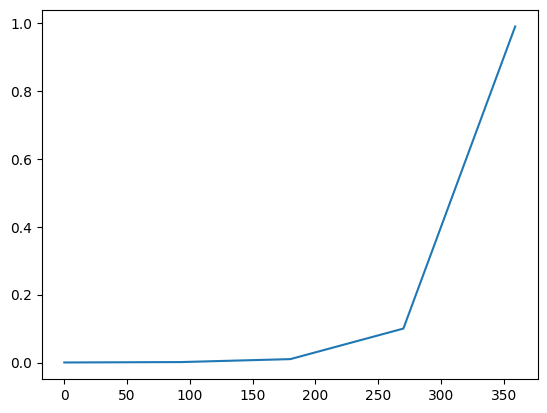

In [23]:
pd.Series(wds).plot();

Next, I'll estimate the disk space required to store the training loss, validation loss and weights for all 360 models (1 per `wd` value).

With ChatGPT's help:

In [24]:
import pickle
import io

def get_pickled_object_size(obj):
    # Create a BytesIO buffer
    buffer = io.BytesIO()
    # Pickle the object into the buffer
    pickle.dump(obj, buffer)
    # Get the size of the buffer
    size = buffer.getbuffer().nbytes
    return size

In [25]:
res = {
    'training_loss': learn.recorder.losses,
    'iters': learn.recorder.iters,
    'valid_cols': learn.recorder.metric_names.index('valid_loss') - 1,
    'validation_loss': L(learn.recorder.values[(np.array(learn.recorder.iters)<5).sum():]).itemgot(learn.recorder.metric_names.index('valid_loss') - 1),
    'weights': torch.nn.utils.parameters_to_vector(learn.model.parameters())
}

In [26]:
size = get_pickled_object_size(res)
print(f'The size of the pickled object for one model is {size/1e6} MB.')
print(f'The total size of the pickled objects for 360 models will be ~{360*size/1e6} MB.')

The size of the pickled object for one model is 2.345662 MB.
The total size of the pickled objects for 360 models will be ~844.43832 MB.


That's quite a bit. And seem unnecessarily large. `learn.recorder.losses` is a list of tensors:

In [27]:
learn.recorder.losses[:5]

[TensorBase(1.8254),
 TensorBase(1.8496),
 TensorBase(1.9542),
 TensorBase(1.8464),
 TensorBase(1.9200)]

Perhaps I can convert that to a list of floats and see if it reduces the storage size:

In [28]:
res = {
    'training_loss': [t.item() for t in learn.recorder.losses],
    'iters': learn.recorder.iters,
    'valid_cols': learn.recorder.metric_names.index('valid_loss') - 1,
    'validation_loss': L(learn.recorder.values[(np.array(learn.recorder.iters)<5).sum():]).itemgot(learn.recorder.metric_names.index('valid_loss') - 1),
    'weights': torch.nn.utils.parameters_to_vector(learn.model.parameters())
}

size = get_pickled_object_size(res)
print(f'The size of the pickled object for one model is {size/1e6} MB.')
print(f'The total size of the pickled objects for 360 models will be ~{360*size/1e6} MB.')

The size of the pickled object for one model is 0.589096 MB.
The total size of the pickled objects for 360 models will be ~212.07456 MB.


That's better! Most of the size is coming from my weights.

In [29]:
size = get_pickled_object_size(torch.nn.utils.parameters_to_vector(learn.model.parameters()))
print(f'The size of the pickled object for one model is {size/1e6} MB.')
print(f'The total size of the pickled objects for 360 models will be ~{360*size/1e6} MB.')

The size of the pickled object for one model is 0.532648 MB.
The total size of the pickled objects for 360 models will be ~191.75328 MB.


With ChatGPT's help: there are 133059 float32 elements in the `weights` tensor. Each float32 element is 4 bytes large. 4 x 133059 is 532236 bytes, which is ~0.5MB. I'll keep them as float32's and accept the larger disk space (since I'm keeping this only temporarily).

## Running the Experiment

Now I can run the experiment and collect the data on it. I'll do a quick run with 3 models and save the `Learner` objects to make sure I'm collecting data correctly.

epoch,train_loss,valid_loss,time
0,0.867206,0.947485,00:12
1,0.612190,0.929238,00:12
2,0.401040,0.964420,00:13
3,0.298337,0.977934,00:12
4,0.293123,0.979958,00:12


epoch,train_loss,valid_loss,time
0,0.879830,0.946919,00:12
1,0.544347,0.930262,00:12
2,0.416691,0.962877,00:12
3,0.298801,0.978486,00:12
4,0.269458,0.979087,00:11


epoch,train_loss,valid_loss,time
0,0.867352,0.940780,00:11
1,0.624375,0.930750,00:12
2,0.405802,0.975494,00:12
3,0.325339,0.991441,00:12
4,0.300811,0.993090,00:12


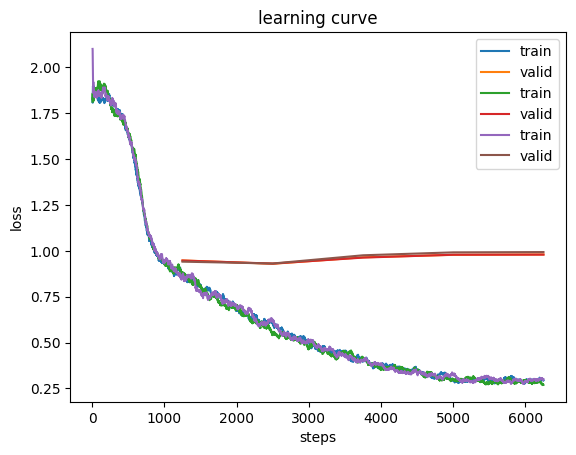

In [30]:
res = {'training_loss': [], 'iters': [], 'validation_loss': [], 'weights': []}
learners = []
count = 0

for wd in wds:
  if count == 3: break
  learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
  learn.fit_one_cycle(5, 5e-3, wd=wd.item())
  learn.recorder.plot_loss();
  learners.append(learn)

  res['training_loss'].append([t.item() for t in learn.recorder.losses])
  res['iters'].append(learn.recorder.iters)
  res['validation_loss'].append(L(learn.recorder.values[(np.array(learn.recorder.iters)<5).sum():]).itemgot(learn.recorder.metric_names.index('valid_loss') - 1))
  res['weights'].append(torch.nn.utils.parameters_to_vector(learn.model.parameters()))
  count += 1

Good to know---it plots on the same chart! I could just use this functionality instead of saving the training and validation loss values, but I want to keep those to do additional visualizations.

Next, I'll check that the recorded values are the same as the `Learner` object.

In [31]:
len(res['training_loss'])

3

In [32]:
res['training_loss'][0] == [t.item() for t in learners[0].recorder.losses], \
res['iters'][1] == learners[1].recorder.iters, \
res['validation_loss'][2] == L(learners[2].recorder.values[(np.array(learners[2].recorder.iters)<5).sum():]).itemgot(learners[2].recorder.metric_names.index('valid_loss') - 1), \
(res['weights'][2] == torch.nn.utils.parameters_to_vector(learners[2].model.parameters())).sum()


(True, True, True, tensor(133059))

Testing that I can pickle and unpickle the results:

In [33]:
save_pickle('wd_res_test.pkl', res)
res = load_pickle('/content/wd_res_test.pkl')

res['training_loss'][0] == [t.item() for t in learners[0].recorder.losses], \
res['iters'][1] == learners[1].recorder.iters, \
res['validation_loss'][2] == L(learners[2].recorder.values[(np.array(learners[2].recorder.iters)<5).sum():]).itemgot(learners[2].recorder.metric_names.index('valid_loss') - 1), \
(res['weights'][2] == torch.nn.utils.parameters_to_vector(learners[2].model.parameters())).sum()

(True, True, True, tensor(133059))

Nice!

However, I noticed that some epochs took up to 13 seconds. I wonder if training time is affected by weight decay value? I'll train with a much larger weight decay and see if it speeds up the training.

In [34]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.9)

epoch,train_loss,valid_loss,time
0,0.990363,1.074203,00:12
1,1.003346,1.067053,00:12
2,0.976281,1.029760,00:12
3,0.978760,1.001970,00:12
4,0.912565,0.993564,00:12


Nope, seems like the training time per epoch just varies.

In [38]:
res = {'wds': wds, 'training_loss': [], 'iters': [], 'validation_loss': [], 'weights': []}

for wd in wds:
  learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
  with learn.no_logging(), learn.no_bar():
    learn.fit_one_cycle(5, 5e-3, wd=wd.item())

  res['training_loss'].append([t.item() for t in learn.recorder.losses])
  res['iters'].append(learn.recorder.iters)
  res['validation_loss'].append(L(learn.recorder.values[(np.array(learn.recorder.iters)<5).sum():]).itemgot(learn.recorder.metric_names.index('valid_loss') - 1))
  res['weights'].append(torch.nn.utils.parameters_to_vector(learn.model.parameters()))

save_pickle('wd_res.pkl', res)

## Analyzing Training Results

### `matplotlib` Animations

I'll create an animation with `matplotlib` which highlights the training loss curve for each weight decay value and prints the weight decay value on the plot.

To start, I'll make sure that all 360 of my training loss lists are of the same length (6250 steps).

In [4]:
#wd_res = load_pickle('/content/wd_res.pkl')

In [10]:
trn_loss_t = torch.stack([torch.tensor(el) for el in wd_res['training_loss']])

In [11]:
trn_loss_t.shape # looks good

torch.Size([360, 6250])

Next, I'll create my `x` values for the plot as a range from 0 to 6249.

In [15]:
x = list(range(len(wd_res['training_loss'][0])))
len(x), x[:5], x[-5:]

(6250, [0, 1, 2, 3, 4], [6245, 6246, 6247, 6248, 6249])

With ChatGPT's help, I used the following code to create an animated GIF which highlights the training and validation loss curves for the given weight decay value.

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Prepare Data
x = list(range(len(wd_res['training_loss'][0])))

data = wd_res['training_loss']

labels = wd_res['wds']

# Create Static Plot
fig, ax = plt.subplots()
ax.set_xlabel('Step')
ax.set_ylabel('Training Loss')

lines = [ax.plot(x, y, alpha=0.0, color='#ff0088', linewidth=2)[0] for y in data]  # Initial lines with lower opacity
text = ax.text(0.5, 1.05, "", transform=ax.transAxes, ha="center")

# Define Animation Function
def animate(i):
    # Reset all lines to low opacity
    for line in lines:
        line.set_alpha(0.0)

    # Highlight the current line
    lines[i].set_alpha(1.0)

    # Update the text
    text.set_text(f"weight decay = {labels[i].item():.5f}")

    return lines + [text]

# Create Animation
ani = FuncAnimation(fig, animate, frames=len(data), interval=150, blit=True)

# Save as GIF
gif_writer = PillowWriter(fps=6)
ani.save('training_loss.gif', writer=gif_writer)

Here's the GIF for training loss. The loss curve slowly moves upward with the minimum loss value increasing as weight decay increases. It really starts picking up at a weight decay value of around 0.1.

![](training_loss.gif)

Here's the GIF for the validation loss---the loss curve starts out decreasing first then increasing and at a weight decay value of around 0.03, starts decreasing monotonically with the minimum loss reaching its minimum. It starts to shift upwards again at around a loss of 0.3.

![](validation_loss.gif)

Next, I'll animate the distribution of the weights (as weight decay value changes), modifying the above code accordingly:

In [ ]:
#| code-fold: true
#| code-summary: "Show the code"

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Prepare Data
data = wd_res['weights']
labels = wd_res['wds']

# Create Static Plot
fig, ax = plt.subplots()
ax.set_xlabel('Weights')
ax.set_ylabel('Count')

# Define Animation Function
def animate(i):
    ax.clear()  # Clear previous histogram
    n, bins, patches = ax.hist(data[i].detach().numpy())
    ax.set_title(f"weight decay = {labels[i].item():.5f}")
    ax.set_xlabel('Weights')
    ax.set_ylabel('Count')
    ax.set_xlim(-0.5, 0.5)  # Set x-axis limits to keep consistent across frames
    ax.set_ylim(0, 75000)  # Set y-axis limits to keep consistent across frames
    return patches

# Create Animation
ani = FuncAnimation(fig, animate, frames=len(data), interval=150, blit=True)

# Save as GIF
gif_writer = PillowWriter(fps=6)
ani.save('weights.gif', writer=gif_writer)

Here's the resulting GIF showing the changing distribution of weights. Note that the range of weights starts out beyond -0.5 to 0.5, and ends up within -0.2 and +0.2 as the weight decay value increases to 1.0.

![](weights.gif)

### Trends

I'll next look at how the final training loss, validation loss and median weight value changes with weight decay values.

In [49]:
min_trn_loss = trn_loss_t.min(dim=-1)[0]
min_trn_loss.shape

torch.Size([360])

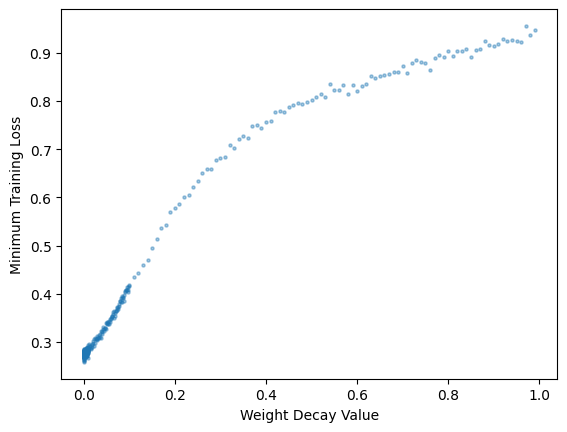

In [61]:
#| code-fold: true
#| code-summary: "Show the code"

plt.scatter(wd_res['wds'], min_trn_loss, s=5, alpha=0.4)

# Set axis labels
plt.xlabel('Weight Decay Value')
plt.ylabel('Minimum Training Loss')

# Display the plot
plt.show();

As the weight-decay value increases, so does the training loss.

In [62]:
val_loss_t = torch.stack([torch.tensor(el) for el in wd_res['validation_loss']])
min_val_loss = val_loss_t.min(dim=-1)[0]
min_val_loss.shape

torch.Size([360])

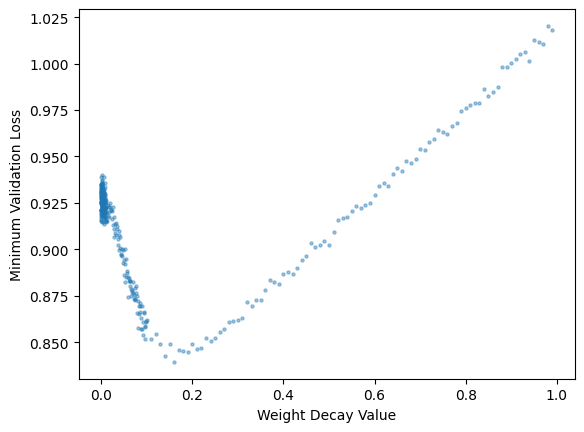

In [63]:
#| code-fold: true
#| code-summary: "Show the code"

plt.scatter(wd_res['wds'], min_val_loss, s=5, alpha=0.4)

# Set axis labels
plt.xlabel('Weight Decay Value')
plt.ylabel('Minimum Validation Loss')

# Display the plot
plt.show();

The minimum validation loss achieved during training reaches a minimum at a weight decay value of around 0.2 and then increases as weight decay increases to 1.0.

In [67]:
weights_t = torch.stack([el.clone().detach() for el in wd_res['weights']])
weights_t.shape

torch.Size([360, 133059])

In [69]:
med_weights_t = weights_t.median(dim=-1)[0]
med_weights_t.shape

torch.Size([360])

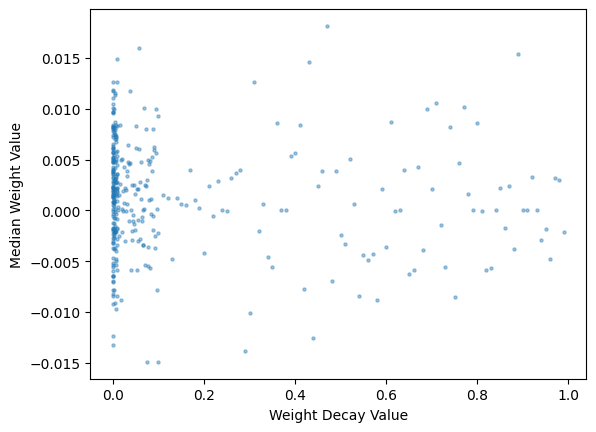

In [77]:
#| code-fold: true
#| code-summary: "Show the code"

plt.scatter(wd_res['wds'], med_weights_t, s=5, alpha=0.4)

# Set axis labels
plt.xlabel('Weight Decay Value')
plt.ylabel('Median Weight Value')

# Display the plot
plt.show();

It's a bit difficult to see trends from this chart, but the but median weights generally seem to be decreasing as weight decay value increaeses--although there is a considerable amount of variability.

In [82]:
mean_weights_t = weights_t.mean(dim=-1)
mean_weights_t.shape

torch.Size([360])

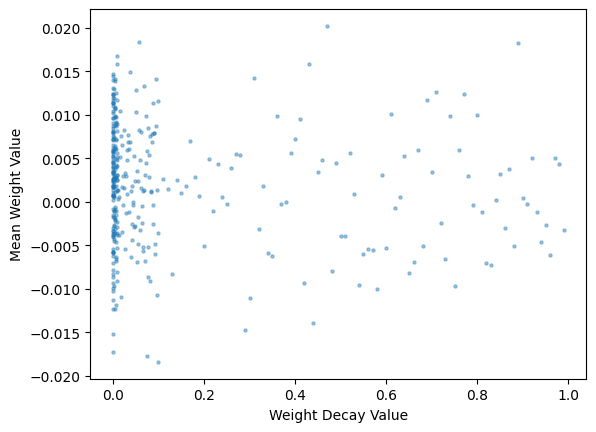

In [83]:
#| code-fold: true
#| code-summary: "Show the code"

plt.scatter(wd_res['wds'], mean_weights_t, s=5, alpha=0.4)

# Set axis labels
plt.xlabel('Weight Decay Value')
plt.ylabel('Mean Weight Value')

# Display the plot
plt.show();

The mean weights follow a similar trend---generally narrowing in range as weight decay value increases. I'll look at the absolute value of mean and median and see if any trends appear:

In [85]:
abs_med_weights_t = weights_t.abs().median(dim=-1)[0]
abs_med_weights_t.shape

torch.Size([360])

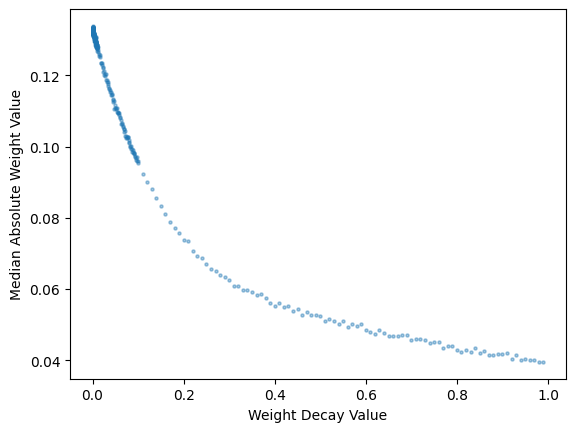

In [86]:
#| code-fold: true
#| code-summary: "Show the code"

plt.scatter(wd_res['wds'], abs_med_weights_t, s=5, alpha=0.4)

# Set axis labels
plt.xlabel('Weight Decay Value')
plt.ylabel('Median Absolute Weight Value')

# Display the plot
plt.show();

That's much clearer! the median absolute value of the weights exponentially decreases as the weight decay value increases. I'll look at the mean absolute value we well:

In [87]:
abs_mean_weights_t = weights_t.abs().mean(dim=-1)
abs_mean_weights_t.shape

torch.Size([360])

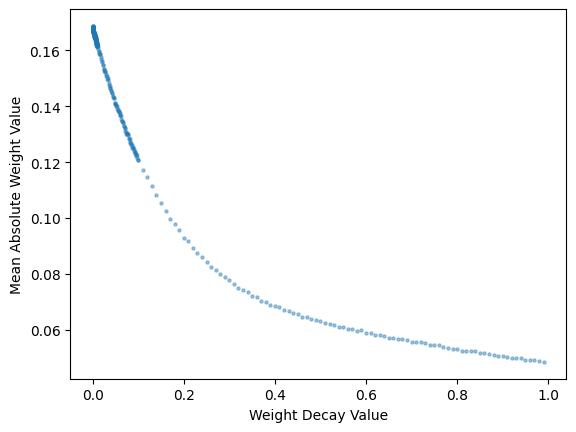

In [88]:
#| code-fold: true
#| code-summary: "Show the code"

plt.scatter(wd_res['wds'], abs_mean_weights_t, s=5, alpha=0.4)

# Set axis labels
plt.xlabel('Weight Decay Value')
plt.ylabel('Mean Absolute Weight Value')

# Display the plot
plt.show();

Yup! The mean absolute value of the weights exponentially decreases as well (as weight decay value goes to 1.0).

## Final Thoughts

As always, I love experimenting with (relatively) simple concepts and observing how they affect training performance and results. Recapping the trends I observed:

- Minimum training loss increases as weight decay increases.
- Minimum validation loss decreases until a point (for this dataset and model, until a weight decay value of ~0.2) and then increases as weight decay increases.
- The mean and median absolute values of the final weights decreases (exponentially) as weight decay increases.

I also enjoyed creating animated GIFs as a visual tool to illustrate the distributions and trends of weights and losses as weight decay increases. The resulting GIFs could be improved by tweaking frame rate and other parameters, but I'm happy with the overall trends they convey, which match the static plots I created.

As always, I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).